In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from read_csv_file import read_csv_file
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/240420131240-Skyline High School.csv'


In [ ]:
df = read_csv_file(file_path)
# if df is not None:
#     print("DataFrame head:\n", df)

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]

# print("Dates:\n", dates.head())
# print("Times:\n", times.head())
# print("Frequency (Hz):\n", frequency)
# print("Data:\n", data.head())

Error reading CSV file: Error tokenizing data. C error: Expected 413 fields in line 214927, saw 496



TypeError: 'NoneType' object is not subscriptable

High variance columns: [     0      1      2 ... 143358 143363 143368]
Low variance rows: [  0   1   2   3   4 347 348 349 350 351 352 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 382 383 384 385 387 388 389 390 391 392 394 395 397 398 400 405
 406 407 408 409 410]


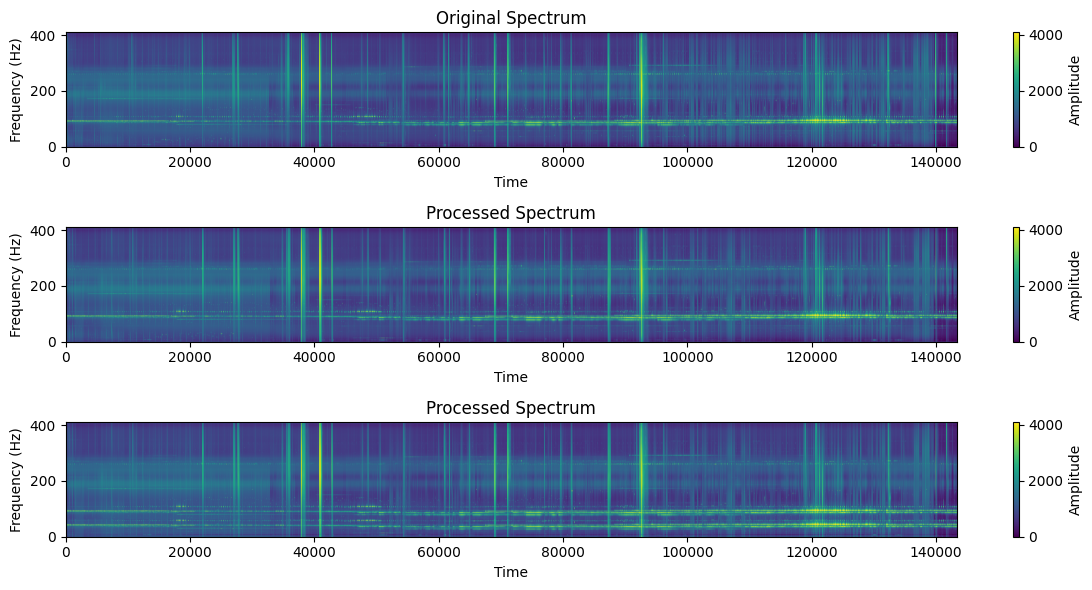

In [14]:
from data_denoise import remove_horizontal_noise, remove_vertical_noise

remove_horizontal_data = remove_horizontal_noise(data)
removed_data = remove_vertical_noise(remove_horizontal_data)
# removed_data = remove_horizontal_data

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.imshow(data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 2)
plt.imshow(remove_horizontal_data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Processed Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 3)
plt.imshow(removed_data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Processed Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

start_index: 141429 end_index: 141859


/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/data_preprocessing/data_label.py:188: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  filtered_mask_df = mask_df.rolling(window=window_size, axis=0, center=True).median()


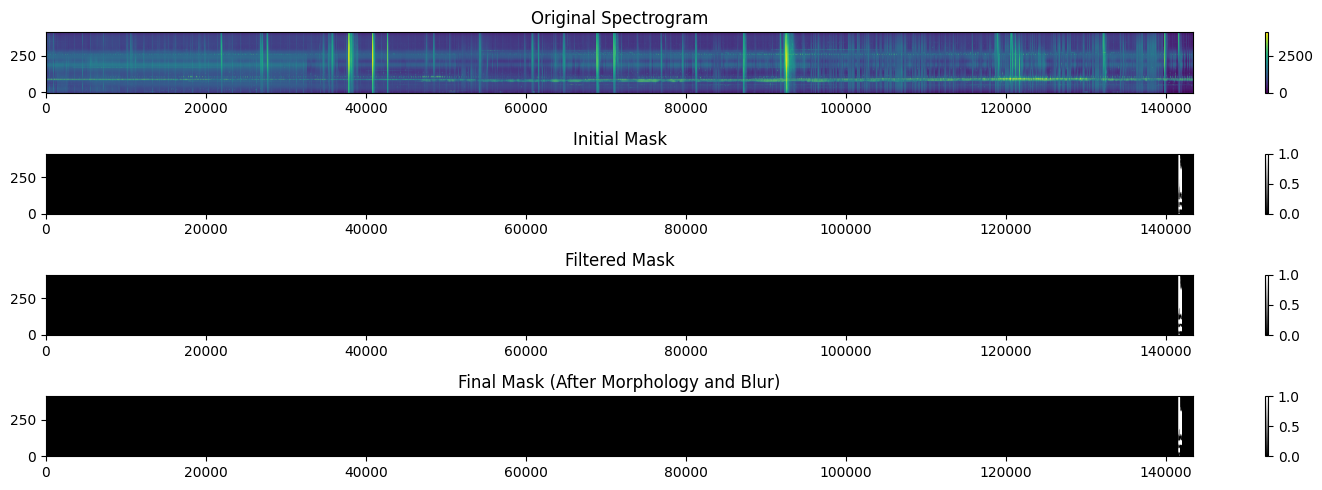

In [171]:
from data_label import time_to_column_indices, create_srb_mask, apply_morphological_operations, blur, apply_rolling_median_filter, intersect_srb_masks

start_time_str = '19:25:05' # Replace with the actual onset time of your data
end_time_str = '19:25:48' # Replace with the actual offset time of your data

start_index, end_index = time_to_column_indices(times, start_time_str, end_time_str)
print("start_index:", start_index, "end_index:", end_index)

# initial_mask = create_srb_mask(data, start_index, end_index, pct_threshold=25)
initial_mask = create_srb_mask(removed_data, start_index, end_index, pct_threshold=25)
morph_mask = apply_morphological_operations(initial_mask, erosion_radius=5, dilation_radius=10, operation_sequence=['erode', 'dilate'])
filtered_mask = apply_rolling_median_filter(morph_mask, window_size=5)
# final_mask = blur(morph_mask, blur_filter_shape=(5, 5))

undeniosed_mask = create_srb_mask(data, start_index, end_index)
undeniosed_morph_mask = apply_morphological_operations(undeniosed_mask, erosion_radius=2, dilation_radius=10, operation_sequence=['erode', 'dilate'])
undeniosed_filtered_mask = apply_rolling_median_filter(undeniosed_morph_mask, window_size=3)

final_mask = intersect_srb_masks(filtered_mask, undeniosed_filtered_mask)

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(4, 1, 1)
plt.imshow(data.T[::-1], aspect='auto', cmap='viridis', origin='lower')
plt.title('Original Spectrogram')
plt.colorbar()

plt.subplot(4, 1, 2)
plt.imshow(initial_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Initial Mask')
plt.colorbar()

plt.subplot(4, 1, 3)
plt.imshow(filtered_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Filtered Mask')
plt.colorbar()

plt.subplot(4, 1, 4)
plt.imshow(final_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Final Mask (After Morphology and Blur)')
plt.colorbar()

plt.tight_layout()
plt.show()

#Filtered mask is Best!
using_data = remove_horizontal_data
using_mask = filtered_mask


In [172]:
# Data Slicing

from data_slicing import SpectrogramSlicer

# Initialize the slicer
slicer = SpectrogramSlicer(target_size=(256, 256), overlap_ratio=0.25, random_offset=False)

# Slice the spectrogram and mask
# Note: 'times' is the array of timestamps, 'using_data' is the spectrogram data, and 'using_mask' is the mask data
slices, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=using_data.T[::-1],
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    mask=using_mask.T[::-1],
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# Output slice information
print(f"Generated {len(slices)} spectrogram slices")
print(f"Slice shape: {slices[0].shape}")
print(f"Mask slice shape: {mask_slices[0].shape}")
print(f"Slice position: {positions}")


Generated 8 spectrogram slices
Slice shape: (256, 256)
Mask slice shape: (256, 256)
Slice position: [(0, 141172), (155, 141172), (0, 141364), (155, 141364), (0, 141556), (155, 141556), (0, 141748), (155, 141748)]


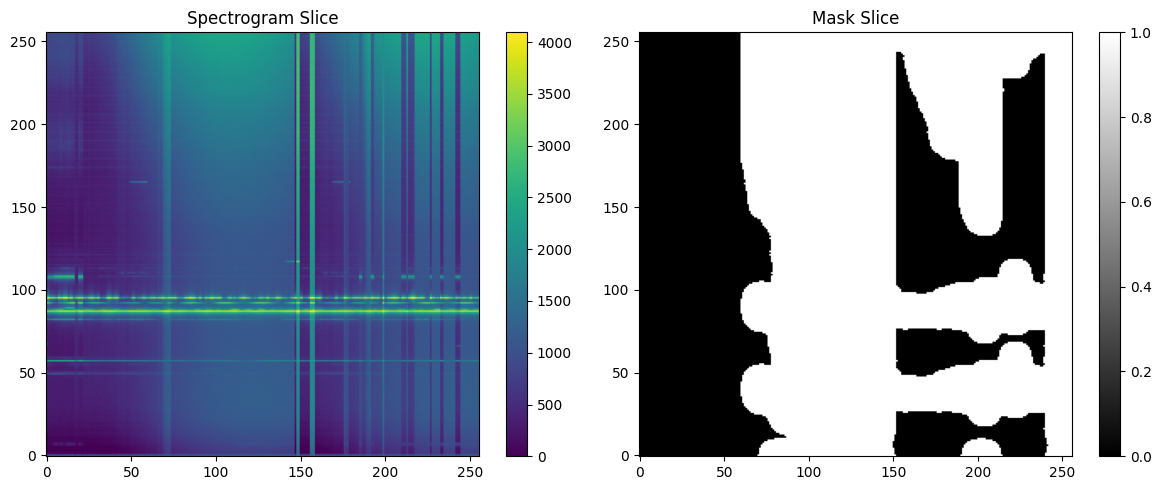

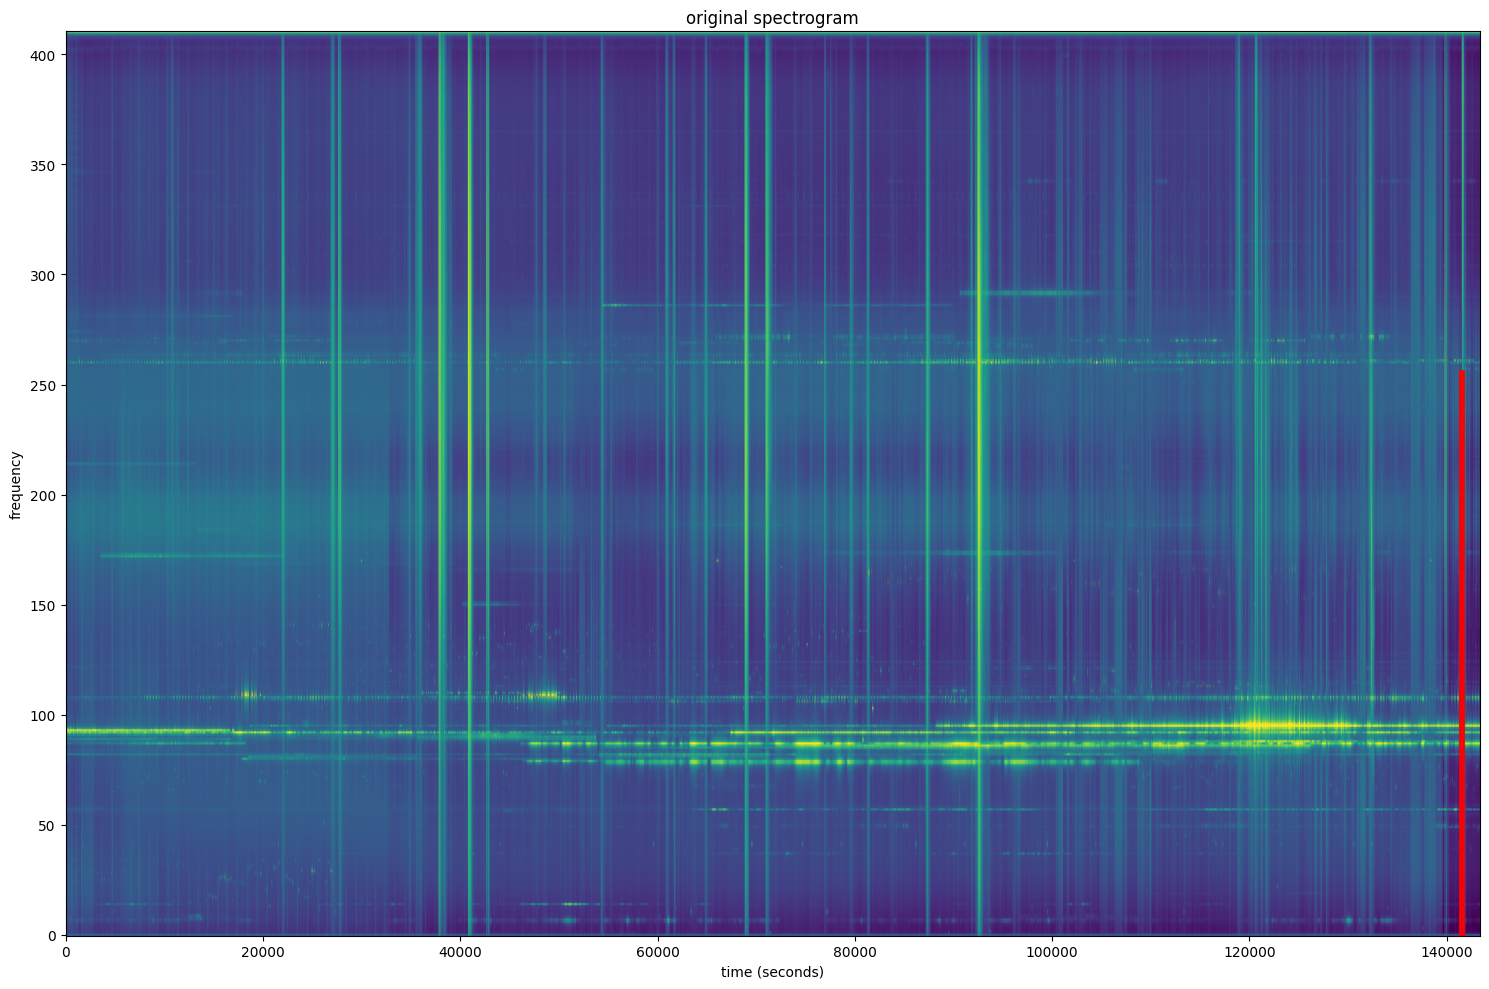

In [173]:

from numpy import min, max
# Optional: Visualize the first slice and its mask

vmin = min(min(using_data))
vmax = max(max(using_data))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(slices[2], aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Spectrogram Slice')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mask_slices[2], aspect='auto', cmap='gray', origin='lower')
plt.title('Mask Slice')
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

# 使用转换后的时间作为 x 轴范围
plt.imshow(using_data.T[::-1], aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
plt.title('original spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('frequency')


if len(positions) > 0:
    y, x = positions[2]  # positions return (y, x)
    # based on the x, find the start and end time
    
    x_start = times[x]
    if x + slicer.target_width < len(times):
        x_end = times[x + slicer.target_width]
    else:
        x_end = times[-1]
    
    y_start = y
    y_end = y + slicer.target_height

    rect = plt.Rectangle((x, y_start), 256, 256, 
                         linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()

In [174]:
# Optional: Save slices to CSV files
metadata = {
    'date': '20240420', # change to the actual date!!!
    'start_time': start_time_str.replace(':', '')
}
save_dir = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices'
saved_files = slicer.save_slices_to_csv(
    slices=slices,
    mask_slices=mask_slices,
    save_dir=save_dir,
    naming_format='slice_{meta_date}_y{y}_x{x}_SkylineHS',  # Naming format
    positions=positions,
    metadata=metadata
)

Saved 8 spectrogram slices to /Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices


In [49]:
# from data_denoise import remove_vertical_noise
from data_label import detect_srb

# cleaned_mask = detect_srb(removed_data)

# plt.subplot(3, 1, 3)
# plt.plot(cleaned_mask, label='Processed Mask', color='orange')
# plt.title('Processed Mask')
# plt.xlabel('Time')
# plt.ylabel('Mask')
# plt.legend()

